# Andrew's segmentation pipeline for D166
- My version of`2019_03_26-andrew-airways-segmentation` notebook

In [1]:
import SimpleITK as sitk
import tlib.lung as tlu

***
## Load volume and denoise it

In [2]:
data_path = os.path.join(home, 'datasets/lung/D166_CT/AX_BONE_.67_5')
sitk_img = tlu.load_dicom_series(data_path)
view = sitk.GetArrayViewFromImage(sitk_img)
info = tlu.get_sitk_image_info(sitk_img)
info

{'size': (768, 768, 824),
 'n_channels': 1,
 'metadata': (),
 'px_type': '16-bit signed integer',
 'origin': (-93.0, 70.0, -296.19000244140625),
 'spacing': (0.260416667, 0.260416667, 0.33001708984375),
 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)}

In [3]:
# tlu.show_sitk_image_3d(sitk_img)
tlu.show_sitk_image_2d_interactive(sitk_img)

interactive(children=(IntSlider(value=411, description='z', max=823), Output()), _dom_classes=('widget-interac…

In [4]:
sitk_img_denoised = sitk.CurvatureFlow(image1=sitk_img, timeStep=0.01, numberOfIterations=30)

In [5]:
tlu.show_sitk_image_2d_interactive(sitk_img_denoised)

interactive(children=(IntSlider(value=411, description='z', max=823), Output()), _dom_classes=('widget-interac…

In [6]:
output_path = os.path.join(data_path, 'D116_denoised.mha')
sitk.WriteImage(sitk_img_denoised, output_path)

***

In [7]:
# output_path = os.path.join(data_path, 'D116_denoised.mha')
# sitk_img_denoised = 

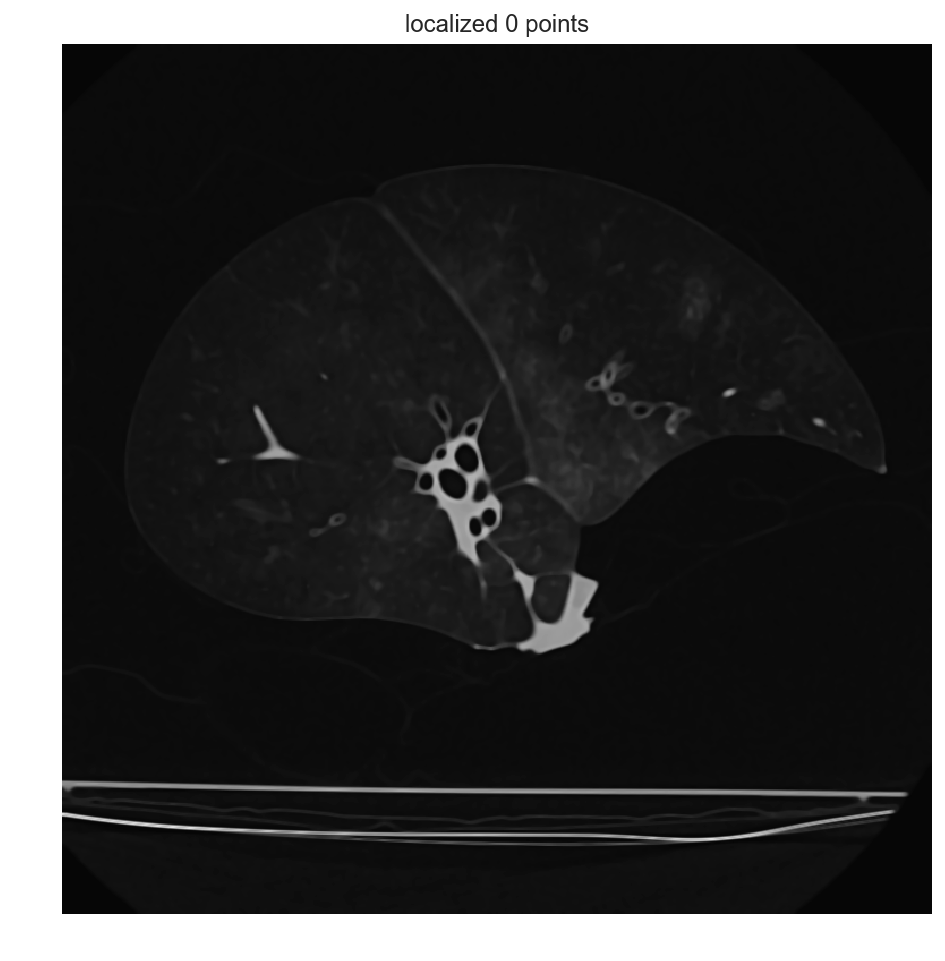

In [10]:
point_acquisition_interface = tlu.PointDataAquisition(sitk_img_denoised)

In [3]:
initial_seed_point_indexes = point_acquisition_interface.get_point_indexes()

In [4]:
seg_implicit_thresholds = sitk.ConfidenceConnected(
    img_D116_smooth,
    seedList=initial_seed_point_indexes,
    numberOfIterations=1,
    multiplier=2.5,
    initialNeighborhoodRadius=1,
    replaceValue=1
)

<IPython.core.display.Javascript object>


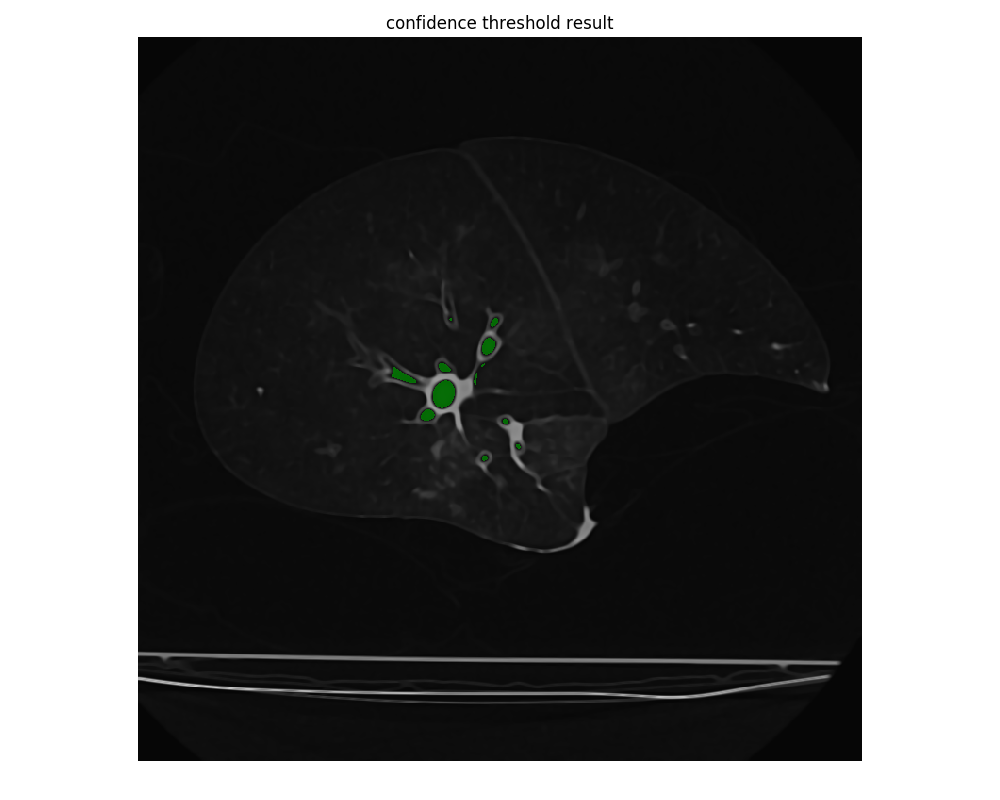

In [5]:
img_int = sitk.Cast(sitk.RescaleIntensity(img_D116_smooth), seg_implicit_thresholds.GetPixelID())
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img_int, seg_implicit_thresholds)],                   
                      title_list = ['confidence threshold result'])

In [7]:
vectorRadius=(1,1,1)
kernel=sitk.sitkBall

seg_implicit_thresholds_clean = sitk.BinaryMorphologicalClosing(seg_implicit_thresholds, 
                                                                vectorRadius,
                                                                kernel)

<IPython.core.display.Javascript object>


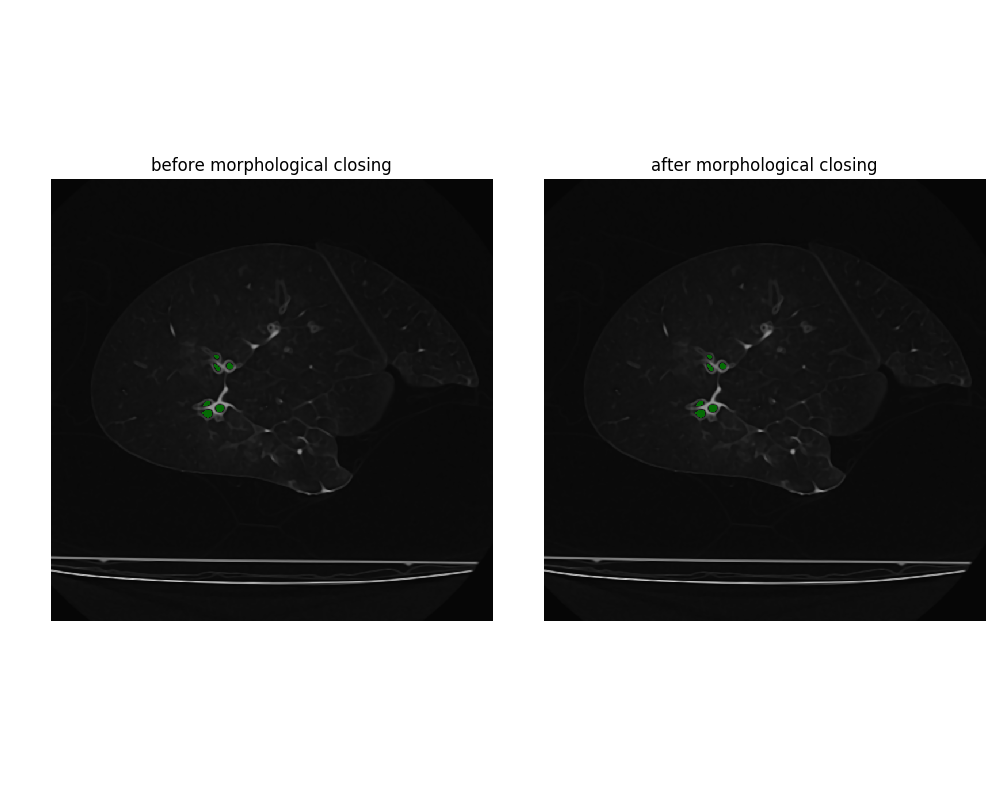

In [8]:
gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(img_int, seg_implicit_thresholds), 
                                sitk.LabelOverlay(img_int, seg_implicit_thresholds_clean)], 
                  shared_slider=True,
                  title_list = ['before morphological closing', 'after morphological closing'])

Morphological closing doesn't seem to do much if the segmentation is already decent. If it's really overblown though, it can help bring it back.

In [40]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize

def make_mesh(image, threshold=-300, step_size=1):

    print ("Transposing surface")
    p = image.transpose(2,1,0)
    
    print ("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, None, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print ("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(250, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(100, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

Transposing surface
Calculating surface
Drawing


<IPython.core.display.Javascript object>


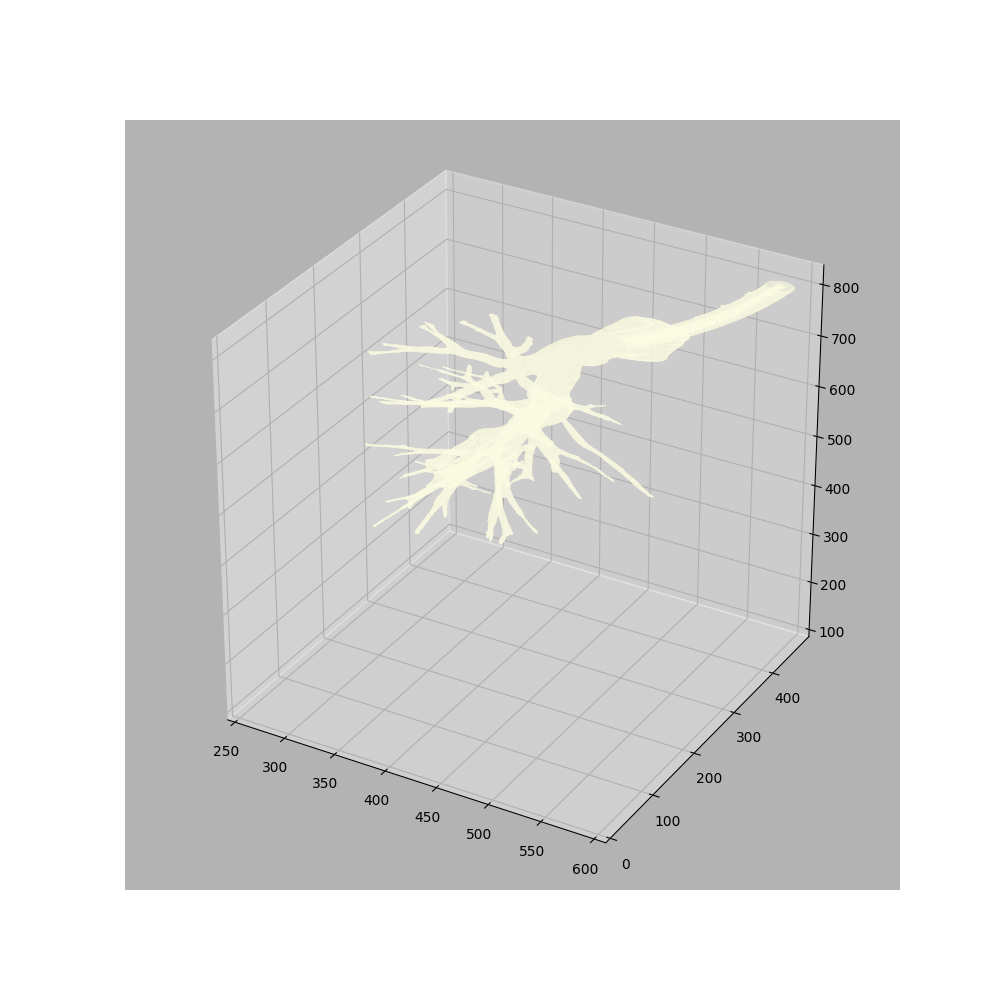

In [41]:
v, f = make_mesh(sitk.GetArrayViewFromImage(seg_implicit_thresholds_clean), 0)
plt_3d(v, f)

In [28]:
import vtk
from IPython.display import Image
def vtk_show(renderer, width=400, height=300):
    """
    Takes vtkRenderer instance and returns an IPython Image with the rendering.
    """
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.SetOffScreenRendering(1)
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(width, height)
    renderWindow.Render()
     
    windowToImageFilter = vtk.vtkWindowToImageFilter()
    windowToImageFilter.SetInput(renderWindow)
    windowToImageFilter.Update()
     
    writer = vtk.vtkPNGWriter()
    writer.SetWriteToMemory(1)
    writer.SetInputConnection(windowToImageFilter.GetOutputPort())
    writer.Write()
    data = str(buffer(writer.GetResult()))
    
    return Image(data)

VTK might work better for plotting but seems to hard to use/poorly documented.
Some hints here: https://pyscience.wordpress.com/2014/09/03/ipython-notebook-vtk/